# Text2Light
This notebook is an all-in-one inference script to generate HDR panorama from free-form texts.

# Setup Environment
This section is intended for run the script in a Colab environment. For a full local setup, we recommend to use [conda environment](https://github.com/FrozenBurning/Text2Light#Installation).

In [1]:
!nvidia-smi

Wed Sep 21 13:16:45 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/FrozenBurning/Text2Light
%cd Text2Light
!mkdir -p logs

In [25]:
!sudo apt-get install libomp-dev
!pip install ftfy regex tqdm omegaconf pytorch-lightning tensorboardX einops transformers
!pip install kornia
!pip install imageio-ffmpeg
!pip install faiss
!pip install opencv-python==4.1.2.30

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libomp-dev is already the newest version (5.0.1-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 12.3 MB/s 
     |████████████████████████████████| 6.6 MB 55.8 MB/s 
     |████████████████████████████████| 120 kB 74.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Load model and config

By default, we download our models from google drive. **However, in case that there are too many downloadings within a day, you can alternatively download model weights from onedrive.**

In [18]:
%cd logs

# using google drive
!gdown --folder https://drive.google.com/drive/folders/1HKBjC7oQOzrkGFKMQmSh6PySv6AycDS3?usp=sharing

# using onedrive, uncomment if download from onedrive
# !mkdir -p text2light_released_model
# !mkdir -p text2light_released_model/global_sampler_clip
# !mkdir -p text2light_released_model/global_sampler_clip/checkpoints
# !mkdir -p text2light_released_model/global_sampler_clip/configs
# !mkdir -p text2light_released_model/local_sampler
# !mkdir -p text2light_released_model/local_sampler/checkpoints
# !mkdir -p text2light_released_model/local_sampler/configs
# !mkdir -p text2light_released_model/local_sampler_indoor
# !mkdir -p text2light_released_model/local_sampler_indoor/checkpoints
# !mkdir -p text2light_released_model/local_sampler_indoor/configs
# !mkdir -p text2light_released_model/local_sampler_outdoor
# !mkdir -p text2light_released_model/local_sampler_outdoor/checkpoints
# !mkdir -p text2light_released_model/local_sampler_outdoor/configs
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EUBiLI5EvFdBr_4fRFNeiScBflkVMSFyYwOqw-n5K8ziYA?e=by0I44&download=1" -O text2light_released_model/global_sampler_clip/checkpoints/last.ckpt
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EYlVpiE_nJlGnGT48XrkOasBsyNhdZpo1o0kBv6GH9d3SQ?e=GnL9rZ&download=1" -O text2light_released_model/global_sampler_clip/configs/2022-04-23T05-49-02-project.yaml
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/Ea4A8VTVNK9LsnGYpFdLMswB9l9vG1g5LGip3M7ZIIJh7Q?e=eeXqA7&download=1" -O text2light_released_model/local_sampler/checkpoints/last.ckpt
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EaQ3yBgd4ehKpoowQHRiKRoBfG9UKetWgAv3KrbSAkyT1Q?e=UbhP4Y&download=1" -O text2light_released_model/local_sampler/configs/2022-04-17T01-29-41-project.yaml
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EYPsy5KO71ZGphgk1YRaMAUB5EQ3GQVZwhF4QKmpASQLxg?e=fMvqU6&download=1" -O text2light_released_model/sritmo.pth
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EceYDnnlH75GlDIpD87C6gsBq4nw98G2m1o8pzycQq23zw?e=4M30wk&download=1" -O text2light_released_model/local_sampler_indoor/checkpoints/last.ckpt
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EWdN7JH-SN5EviwPu932v28BvX5B-4Pm10vzr0CVqRVHRA?e=3XTjD2&download=1" -O text2light_released_model/local_sampler_indoor/configs/2022-04-26T13-11-31-project.yaml
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/EUP4I6v04PtDgBlNiMCQDtkB_LKnIT9zuQ2oFAWsoXiVkg?e=CewsEE&download=1" -O text2light_released_model/local_sampler_outdoor/checkpoints/last.ckpt
# !wget "https://entuedu-my.sharepoint.com/:u:/g/personal/zhaoxi001_e_ntu_edu_sg/ERs_SkZ9f_VOoeYBk1xSC0MBkr3SHIs7rlykHKCkXxZhuA?e=hoAG4w&download=1" -O text2light_released_model/local_sampler_outdoor/configs/2022-04-29T20-25-45-project.yaml

%cd ..

/content/Text2Light/logs
Retrieving folder list
Retrieving folder 1d-TyBKJHSZ_gCbhZ4nB3gyViwpGEwW5S global_sampler_clip
Retrieving folder 19Fv5cuySmDbQw4w6ejwpndojjbvWAPqJ checkpoints
Processing file 1TcdfL-pyPrUlcMSsGuiaB6-UqTLrqDkv last.ckpt
Retrieving folder 1YzuKkv0C3RbbPceKktI3mxPWuTcud1F- configs
Processing file 1fjqhRYT4n1vv17y-sKwhijJIVgeVZYtb 2022-04-23T05-49-02-lightning.yaml
Processing file 1By_DB78XDQPSR047ZuT1q4Z1zOLz7mCA 2022-04-23T05-49-02-project.yaml
Retrieving folder 10Lwiy_c38WhC_dbKiGzQWY1dCYpd68Gc local_sampler
Retrieving folder 1mX7AsRQfMjPvT4Bpf7R3iLPGCMVcCDFh checkpoints
Processing file 1gEvq-TsuVxGKnABqGjfEbK0o-TQL2ovj last.ckpt
Retrieving folder 1KqSkiWy-Yxx1qUySOf3zBWY1CbVCKBM9 configs
Processing file 1MOsBU9XtLNEuxWCR3lWdVRulCv1bi6Mq 2022-04-17T01-29-41-lightning.yaml
Processing file 1jBdezuWlSfFaCgERaK3znTkPWhWOcOo_ 2022-04-17T01-29-41-project.yaml
Retrieving folder 1ppViSo6M4XLm0IP_HYyj5bbm_rcn8s-l local_sampler_indoor
Retrieving folder 13LuKST8qOAJp0PQqHe

# Import libraries

In [45]:
import argparse, os, sys, glob
import cv2
import torch
import faiss
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm

import clip
from taming.util import instantiate_from_config
from sritmo.global_sritmo import SRiTMO

# Define some utilities

In [46]:
def save_image(x, path):
    c,h,w = x.shape
    assert c==3
    x = ((x.detach().cpu().numpy().transpose(1,2,0)+1.0)*127.5).clip(0,255).astype(np.uint8)
    s = Image.fromarray(x)
    s.save(path)
    return s


def get_knn(database: np.array, index: faiss.Index, txt_emb, k = 5):
    dist, idx  = index.search(txt_emb, k)
    return database[idx], idx #[bs, k, 512]


@torch.no_grad()
def text2light(models: dict, prompts, outdir, params: dict):
    # models
    global_sampler = models["gs"]
    local_sampler = models["ls"]
    # params
    batch_size = len(prompts)
    top_k = params["top_k"]
    temperature = params['temperature']
    database = params['data4knn']
    faiss_index = params['index4knn']
    device = params['device']

    # embed input texts
    lan_model, _ = clip.load("ViT-B/32", device=device)
    lan_model.eval()
    text = clip.tokenize(prompts).to(device)
    text_features = lan_model.encode_text(text)
    target_txt_emb = text_features / text_features.norm(dim=-1, keepdim=True)
    cond, _ = get_knn(database, faiss_index, target_txt_emb.cpu().numpy().astype('float32'))
    txt_cond = torch.from_numpy(cond.reshape(batch_size, 5, cond.shape[-1]))
    txt_cond = torch.cat([txt_cond, txt_cond,], dim=-1).to(device)

    # sample holistic condition
    bs = batch_size
    start = 0
    idx = torch.zeros(bs, 1, dtype=int)[:, :start].to(device)
    cshape = [bs, 256, 8, 16]
    sample = True

    print("Generating holistic conditions according to texts...")
    for i in tqdm(range(start, cshape[2]*cshape[3])):
        logits, _ = global_sampler.transformer(idx, embeddings=txt_cond)
        logits = logits[:, -1, :]
        if top_k is not None:
            logits = global_sampler.top_k_logits(logits, top_k)
        probs = torch.nn.functional.softmax(logits, dim=-1)
        if sample:
            ix = torch.multinomial(probs, num_samples=1)
        else:
            _, ix = torch.topk(probs, k=1, dim=-1)
        idx = torch.cat((idx, ix), dim=1)

    xsample_holistic = global_sampler.decode_to_img(idx, cshape)
    for i in range(xsample_holistic.shape[0]):
        holistic_save = save_image(xsample_holistic[i], os.path.join(outdir, "holistic", "holistic_[{}].png".format(prompts[i])))

    print("Synthesizing patches...")
    # synthesize patch by patch according to holistic condition
    h = 512
    w = 1024
    xx, yy = np.meshgrid(np.linspace(0, 1, w), np.linspace(0, 1, h))
    screen_points = np.stack([xx, yy], axis=-1)
    coord = (screen_points * 2 - 1) * np.array([np.pi, np.pi/2])
    spe = torch.from_numpy(coord).to(xsample_holistic).repeat(xsample_holistic.shape[0], 1, 1, 1).permute(0, 3, 1, 2)
    spe = torch.nn.functional.interpolate(spe, scale_factor=1/8,
                                            mode="bicubic", recompute_scale_factor=False, align_corners=True)
    spe = local_sampler.embedder(spe.permute(0, 2, 3, 1))
    spe = spe.permute(0, 3, 1, 2)

    _, h_indices = local_sampler.encode_to_h(xsample_holistic)
    cshape = [xsample_holistic.shape[0], 256, h // 16, w // 16]
    idx = torch.randint(0, 1024, (cshape[0], cshape[2], cshape[3])).to(h_indices)
    idx = idx.reshape(cshape[0], cshape[2], cshape[3])

    start = 0
    start_i = start // cshape[3]
    start_j = start % cshape[3]
    sample = True

    for i in tqdm(range(start_i, cshape[2])):
        if i <= 8:
            local_i = i
        elif cshape[2]-i < 8:
            local_i = 16-(cshape[2]-i)
        else:
            local_i = 8
        for j in range(start_j, cshape[3]):
            if j <= 8:
                local_j = j
            elif cshape[3]-j < 8:
                local_j = 16-(cshape[3]-j)
            else:
                local_j = 8

            i_start = i-local_i
            i_end = i_start+16
            j_start = j-local_j
            j_end = j_start+16
            patch = idx[:,i_start:i_end,j_start:j_end]
            patch = patch.reshape(patch.shape[0],-1)
            cpatch = spe[:, :, i_start*2:i_end*2,j_start*2:j_end*2]
            cpatch = cpatch.reshape(cpatch.shape[0], local_sampler.cdim, -1)
            patch = torch.cat((h_indices, patch), dim=1)
            logits, _ = local_sampler.transformer(patch[:,:-1], embeddings=cpatch)
            logits = logits[:, -256:, :]
            logits = logits.reshape(cshape[0],16,16,-1)
            logits = logits[:,local_i,local_j,:]
            logits = logits / temperature

            if top_k is not None:
                logits = local_sampler.top_k_logits(logits, top_k)
            # apply softmax to convert to probabilities
            probs = torch.nn.functional.softmax(logits, dim=-1)
            # sample from the distribution or take the most likely
            if sample:
                ix = torch.multinomial(probs, num_samples=1)
            else:
                _, ix = torch.topk(probs, k=1, dim=-1)
            idx[:,i,j] = ix.reshape(-1)
    xsample = local_sampler.decode_to_img(idx, cshape)
    for i in range(xsample.shape[0]):
        ldr_save = save_image(xsample[i], os.path.join(outdir, "ldr", "ldr_[{}].png".format(prompts[i])))

    # super-resolution inverse tone mapping
    if params['sritmo'] is not None:
        ldr_hr_samples, hdr_hr_samples = SRiTMO(xsample, params)
    else:
        print("no checkpoint provided, skip Stage II (SR-iTMO)...")
        return
    
    for i in range(xsample.shape[0]):
        ldr_hr_save = (ldr_hr_samples[i].permute(1, 2, 0).detach().cpu().numpy() + 1) * 127.5
        cv2.imwrite(os.path.join(outdir, "ldr", "hrldr_[{}].png".format(prompts[i])), ldr_hr_save)
        cv2.imwrite(os.path.join(outdir, "hdr", "hdr_[{}].exr".format(prompts[i])), hdr_hr_samples[i].permute(1, 2, 0).detach().cpu().numpy())
    return ldr_hr_save
    

def load_model_from_config(config, sd, gpu=True, eval_mode=True):
    if "ckpt_path" in config.params:
        print("Deleting the restore-ckpt path from the config...")
        config.params.ckpt_path = None
    if "downsample_cond_size" in config.params:
        print("Deleting downsample-cond-size from the config and setting factor=0.5 instead...")
        config.params.downsample_cond_size = -1
        config.params["downsample_cond_factor"] = 0.5
    try:
        if "ckpt_path" in config.params.first_stage_config.params:
            config.params.first_stage_config.params.ckpt_path = None
            print("Deleting the first-stage restore-ckpt path from the config...")
        if "ckpt_path" in config.params.cond_stage_config.params:
            config.params.cond_stage_config.params.ckpt_path = None
            print("Deleting the cond-stage restore-ckpt path from the config...")
        if "ckpt_path" in config.params.holistic_config.params:
            config.params.holistic_config.params.ckpt_path = None
            print("Deleting the global sampler restore-ckpt path from the config...")
    except:
        pass

    model = instantiate_from_config(config)
    if sd is not None:
        missing, unexpected = model.load_state_dict(sd, strict=False)
        print(f"Missing Keys in State Dict: {missing}")
        print(f"Unexpected Keys in State Dict: {unexpected}")
    if gpu:
        model.cuda()
    if eval_mode:
        model.eval()
    return {"model": model}

def load_model(config, ckpt, gpu, eval_mode):
    if ckpt:
        raw_model = torch.load(ckpt, map_location="cpu")
        state_dict = raw_model["state_dict"]
    else:
        raise NotImplementedError("checkpoint at [{}] is not found!".format(ckpt))
    model = load_model_from_config(config.model, state_dict, gpu=gpu, eval_mode=eval_mode)["model"]
    return model

# Settings for this run
Mainly what you will have to modify will be `texts`. Please input your scene description in the text box which could be a free-form sentence. Given the limited GPU capacity of Colab, we only support generating one HDRI per inference time. To generate multiple HDRIs with a list of input texts, please refer to our [repo](https://github.com/FrozenBurning/Text2Light) for a full local installation.

`model:` We use the model trained on our full dataset by default. Note that we also release models that trained on outdoor and indoor scenes respectively.

`sritmo:` Specify sritmo to enable super-resolution and inverse tonemapping.

In [50]:
#@title Parameters
texts = "ocean waves crashing on shore under blue and white cloudy sky during daytime" #@param {type:"string"}
model = "full" #@param ["full", "outdoor", "indoor"]
sritmo = True #@param {type:"boolean"}
sr_factor = 4 #@param {type:"number"}
top_k = 100 #@param {type:"number"}
temperature = 1.0 #@param {type:"number"}

local_sampler_path = None
if model == "full":
  local_sampler_path = "./logs/text2light_released_model/local_sampler/"
elif model == "outdoor":
  local_sampler_path = "./logs/text2light_released_model/local_sampler_outdoor/"
elif model == "indoor":
  local_sampler_path = "./logs/text2light_released_model/local_sampler_indoor/"
else:
  raise NotImplementedError

sritmo_path = None
if sritmo:
  sritmo_path = "./logs/text2light_released_model/sritmo.pth"


opt = argparse.Namespace(
    resume_global="./logs/text2light_released_model/global_sampler_clip/",
    resume_local=local_sampler_path,
    sritmo=sritmo_path,
    sr_factor=sr_factor,
    outdir="./text2light_generated",
    clip="./clip_emb.npy",
    text=texts,
    top_k=top_k,
    temperature=temperature,
    bs=1,
)


# Run Text2Light!
All outputs (including high-resolution HDR, LDR) will be saved in `./text2light_generated`.

Resuming from global sampler ckpt...
logdir:./logs/text2light_released_model/global_sampler_clip
./logs/text2light_released_model/global_sampler_clip/checkpoints/last.ckpt
Deleting the first-stage restore-ckpt path from the config...
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Missing Keys in State Dict: []
Unexpected Keys in State Dict: []
Resuming from local sampler ckpt...
logdir:./logs/text2light_released_model/local_sampler
./logs/text2light_released_model/local_sampler/checkpoints/last.ckpt
Deleting the first-stage restore-ckpt path from the config...
Deleting the global sampler restore-ckpt path from the config...
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Working with z of shape (1, 256, 16, 16) = 65536 dimensions.
Missing Keys in State Dict: []
Unexpected Keys in State Dict: []
Writing samples to  ./text2light_generated
Ge

100%|██████████| 128/128 [00:01<00:00, 72.81it/s]


Synthesizing patches...


100%|██████████| 32/32 [03:38<00:00,  6.84s/it]


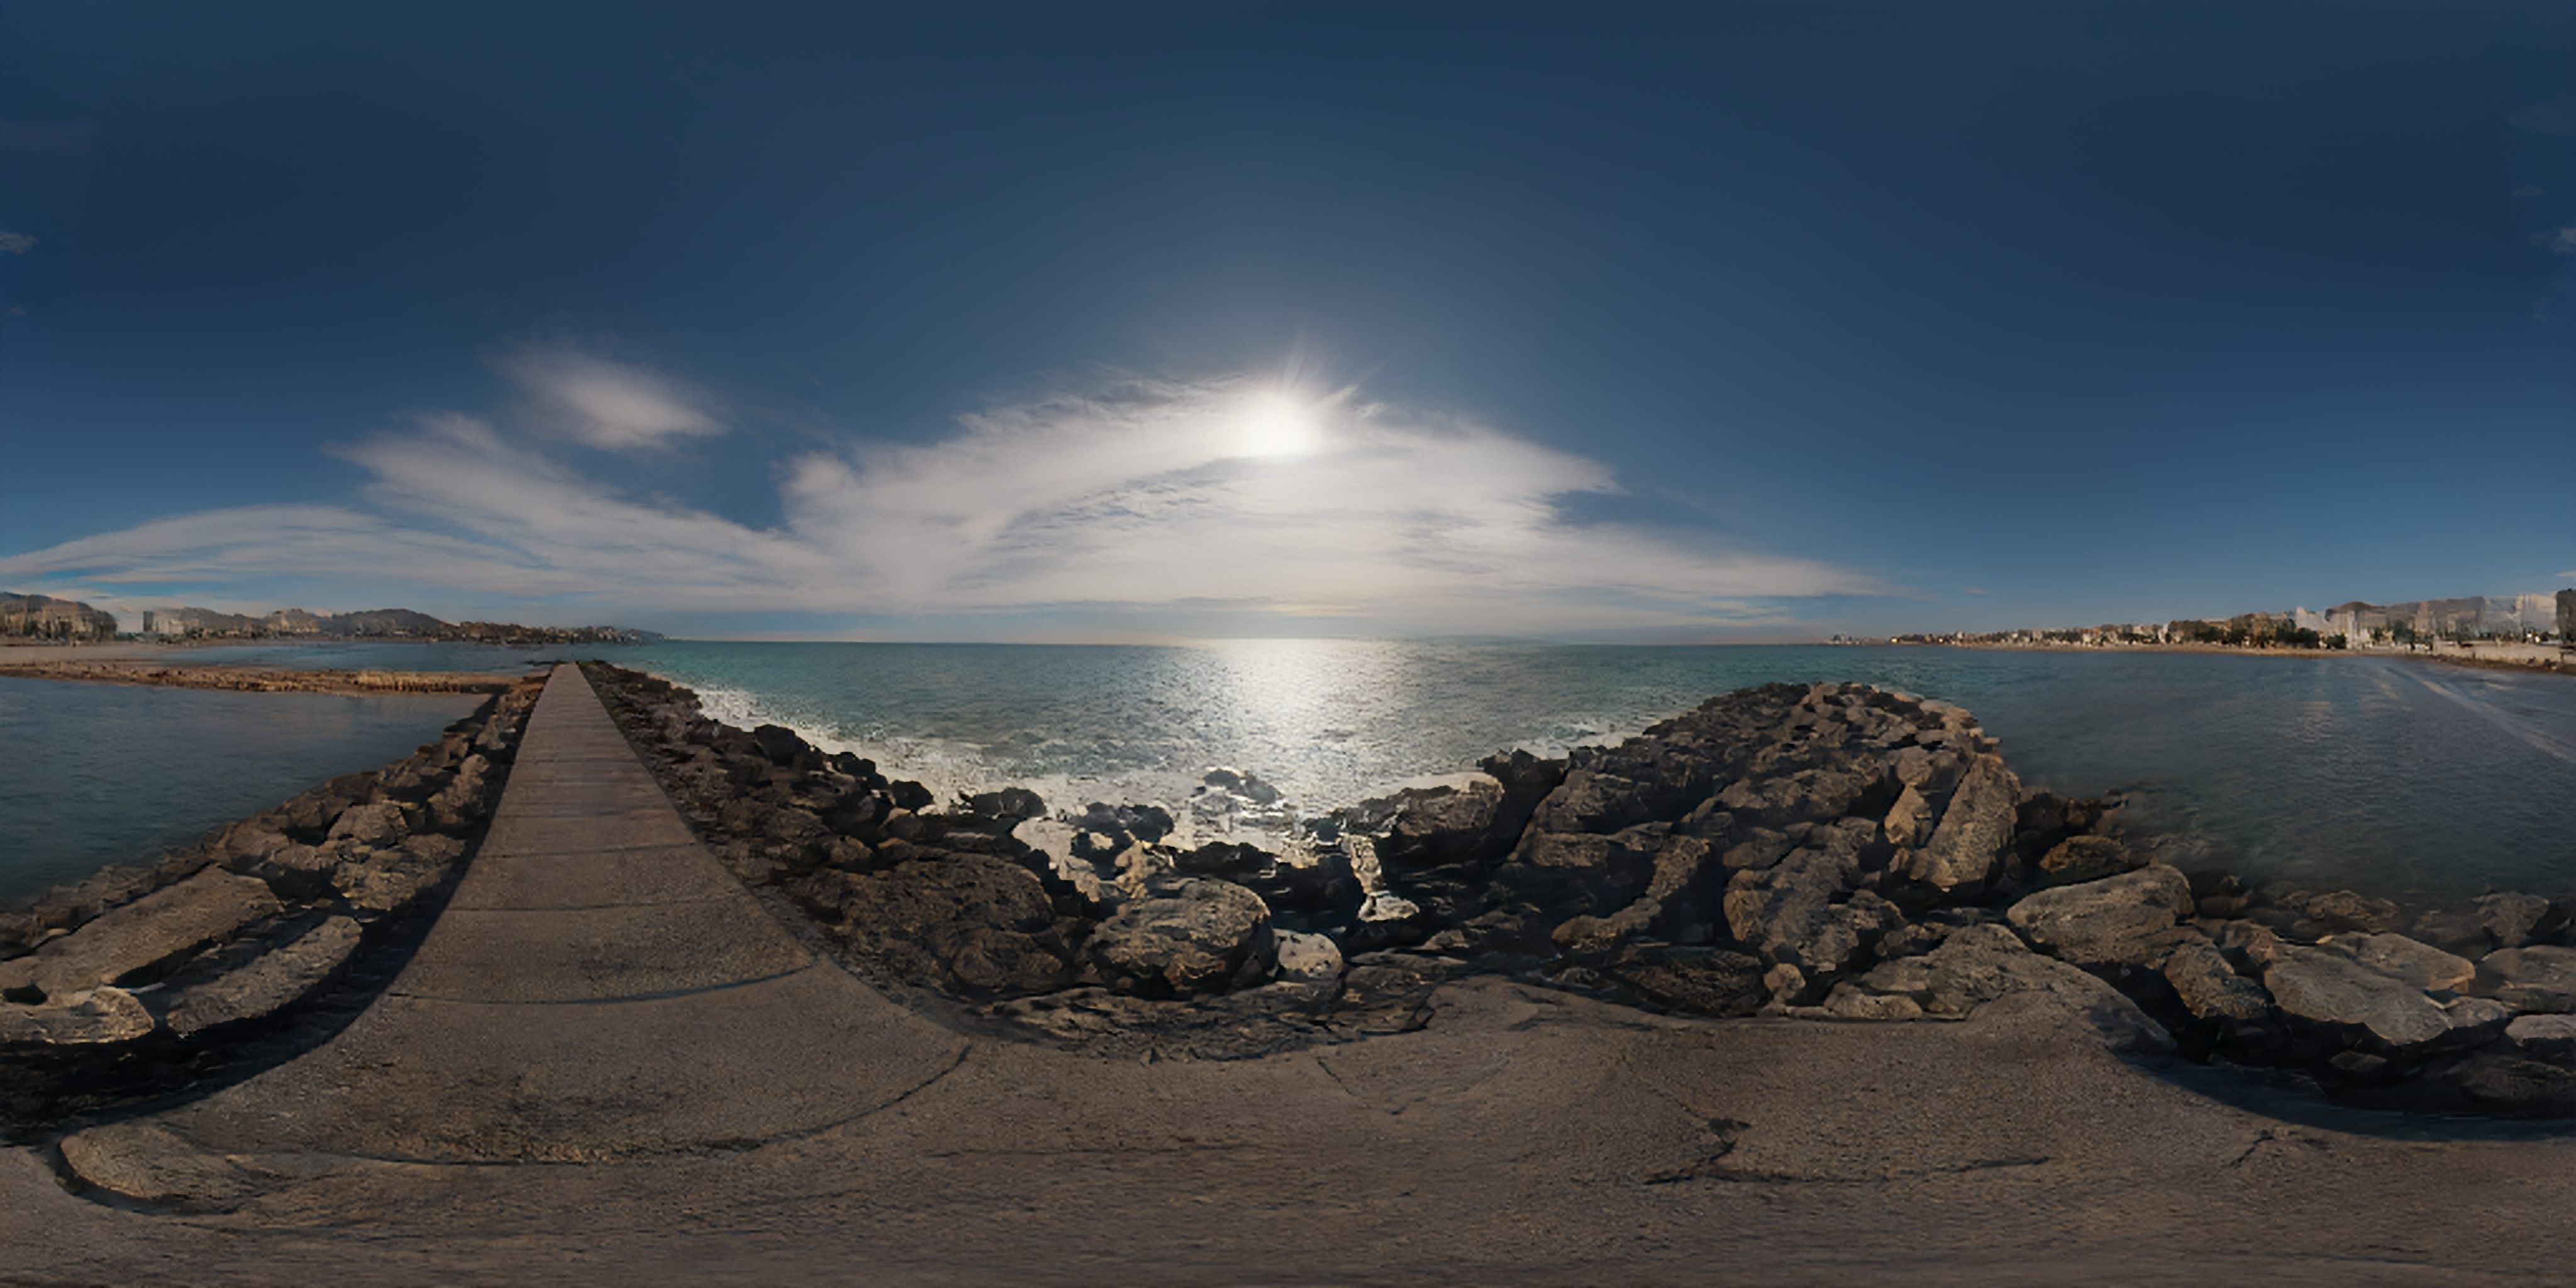

In [51]:
sys.path.append(os.getcwd())
unknown=[]
gpu = True
eval_mode = True
show_config = False

base = list()

ckpt = None
if opt.resume_global:
    if not os.path.exists(opt.resume_global):
        raise ValueError("Cannot find {}".format(opt.resume_global))
    print("Resuming from global sampler ckpt...")
    assert os.path.isdir(opt.resume_global), opt.resume_global
    logdir = opt.resume_global.rstrip("/")
    ckpt = os.path.join(logdir, "checkpoints", "last.ckpt")
    print(f"logdir:{logdir}")
    base_configs = sorted(glob.glob(os.path.join(logdir, "configs/*-project.yaml")))
    config2load = base_configs + base

configs = [OmegaConf.load(cfg) for cfg in config2load]
cli = OmegaConf.from_dotlist(unknown)
config = OmegaConf.merge(*configs, cli)

print(ckpt)
if show_config:
    print(OmegaConf.to_container(config))

global_sampler = load_model(config, ckpt, gpu, eval_mode)

ckpt = None
if opt.resume_local:
    if not os.path.exists(opt.resume_local):
        raise ValueError("Cannot find {}".format(opt.resume_local))
    print("Resuming from local sampler ckpt...")
    assert os.path.isdir(opt.resume_local), opt.resume_local
    logdir = opt.resume_local.rstrip("/")
    ckpt = os.path.join(logdir, "checkpoints", "last.ckpt")
    print(f"logdir:{logdir}")
    base_configs = sorted(glob.glob(os.path.join(logdir, "configs/*-project.yaml")))
    config2load = base_configs + base

configs = [OmegaConf.load(cfg) for cfg in config2load]
cli = OmegaConf.from_dotlist(unknown)
config = OmegaConf.merge(*configs, cli)
print(ckpt)
if show_config:
    print(OmegaConf.to_container(config))

local_sampler = load_model(config, ckpt, gpu, eval_mode)

outdir = opt.outdir
os.makedirs(outdir, exist_ok=True)
print("Writing samples to ", outdir)
for k in ["holistic", "ldr", "hdr"]:
    os.makedirs(os.path.join(outdir, k), exist_ok=True)
    
prompts_file = opt.text
if os.path.exists(prompts_file):
    # list of prompts for text2light tasks
    with open(prompts_file, 'r') as f:
        prompts = f.read().splitlines()
else:
    # a single prompt
    prompts = [prompts_file]

# construct knn searching base
if os.path.isfile(opt.clip):
    clip_emb = np.load(opt.clip).astype('float32')
else:
    raise NotImplementedError('The path [{}] to clip embedding is not valid.'.format(opt.clip))
    
knn_index = faiss.IndexFlatIP(clip_emb.shape[-1])
knn_index.add(clip_emb)

input_models = {
    'gs': global_sampler,
    'ls': local_sampler,
}

input_params = {
    'top_k': opt.top_k,
    'temperature': opt.temperature,
    'device': 'cuda' if gpu else 'cpu',
    'data4knn': clip_emb,
    'index4knn': knn_index,
    'sritmo': opt.sritmo,
    'sr_factor': opt.sr_factor,
}
for i in range(0, len(prompts), opt.bs):
    end_i = min(len(prompts), i + opt.bs)
    prompt = prompts[i: i+opt.bs]
    result = text2light(input_models, prompt, outdir, input_params)
    display(Image.fromarray(result[:, :, [2, 1, 0]].clip(0,255).astype(np.uint8)))